# Anchor-Anchor Hidden Distance
**Goal**: Analyze the distance between the hidden representation of each set of anchors

In [1]:
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import cosine_distances, manhattan_distances
sns.set_style('darkgrid')

# Load Data

In [2]:
LAYER = 'hidden'
TYPE = 'anchor'

In [3]:
# Load anchor-probes mapping
anchor_probe_mapping = pd.read_pickle(f'../../dataset/anchor_probe_mapping_dilution_3.pkl')
anchor_probe_mapping = anchor_probe_mapping.rename(columns={'probes': 'probe'})
anchor_probe_mapping.head()

,anchor,probe,type
0,"[slit, dit, yit]","[vlit, plit, trit, drit]",REG
1,"[thax, chax, brax]","[frax, drax, prax, shrax]",REG
2,"[kleef, pleef, smeef]","[bleef, gleef, creef, preef]",REG
3,"[krim, plim, drim]","[blim, clim, shrim, frim]",REG
4,"[nisp, fisp, chisp]","[bisp, kisp, risp, tisp]",REG


In [4]:
all_data = []

for dilution in tqdm(range(1, 4)):
    word_list = sum(anchor_probe_mapping[TYPE].apply(lambda x: x[:dilution]).tolist(), [])
    word_types = [f"{'ANC' if TYPE == 'anchor' else 'PRO'}_{i}" for i in ['REG', 'EXC', 'AMB']]
    
    # Load probes data
    data = pd.concat([pd.read_pickle(f'pmsp-recurrent-dt-100-seed-1/activations-{TYPE}s-{LAYER}.pkl'),
                      pd.read_pickle(f'pmsp-recurrent-dt-100-dilution-{dilution}-seed-1/activations-{TYPE}s-{LAYER}.pkl')])
    
    data = data[data['word_type'].isin(word_types)]
    data = data[data['orth'].isin(word_list)]
    data = data.drop_duplicates(subset=['epoch', 'orth'])
    data['dilution'] = dilution
    all_data.append(data)

all_data = pd.concat(all_data).reset_index(drop=True)


100%|██████████| 3/3 [00:12<00:00,  4.18s/it]


In [5]:
all_data.head()

,epoch,hidden,word_id,orth,phon,word_type,dilution
0,0,"[0.5810385, 0.03448805, 0.7988132, 0.9942407, ...",0,slit,slit,ANC_REG,1
1,0,"[0.5104707, 0.2259514, 0.4384914, 0.9883878, 0...",34,drace,dro,ANC_EXC,1
2,0,"[0.7540455, 0.4483854, 0.2318757, 0.99431, 0.4...",8,shing,SiN,ANC_REG,1
3,0,"[0.4388078, 0.1719238, 0.6234508, 0.9161762, 0...",39,suff,sUf,ANC_EXC,1
4,0,"[0.2659034, 0.02671888, 0.1501291, 0.9853213, ...",36,geam,jem,ANC_EXC,1


## Calculation of Distance

We use two distance metrics - cosine distance, and L1 distance. The documentation for these two distance metrics are available here:
* [Cosine Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html#sklearn.metrics.pairwise.cosine_distances)
* [Manhattan Distance](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.manhattan_distances.html#sklearn.metrics.pairwise.manhattan_distances)

In [6]:
results = []
for dilution in [2, 3]:
    data = all_data[all_data['dilution'] == dilution]

    for i, row in tqdm(anchor_probe_mapping.iterrows(), total=len(anchor_probe_mapping), desc=f"Dilution {dilution}"):
        word_data = data[data['orth'].isin(row[TYPE])]
        for epoch in data['epoch'].unique():
            epoch_data = np.array(word_data[word_data['epoch'] == epoch][LAYER].tolist())

            results.append({
                'dilution': dilution,
                'epoch': epoch,
                f'{TYPE}s': row[TYPE],
                'type': row['type'],
                'cosine_distances': cosine_distances(epoch_data, epoch_data),
                'l1_distances': manhattan_distances(epoch_data, epoch_data)
            })

Dilution 3: 100%|██████████| 27/27 [00:01<00:00, 14.45it/s]


In [7]:
results_df = pd.DataFrame(results)
results_df['mean_cosine_distance'] = results_df['cosine_distances'].apply(lambda x: x.mean())
results_df['mean_l1_distance'] = results_df['l1_distances'].apply(lambda x: x.mean())
results_df[f'first_{TYPE}'] = results_df[f'{TYPE}s'].apply(lambda x: x[0])
results_df = results_df.sort_values(by=['epoch', 'type', f'first_{TYPE}']).reset_index(drop=True)

In [8]:
results_df.head()

,dilution,epoch,anchors,type,cosine_distances,l1_distances,mean_cosine_distance,mean_l1_distance,first_anchor
0,2,0,"[blome, clome, flome]",AMB,"[[0.0, 0.01558460179807064], [0.01558460179807...","[[0.0, 7.617066381100002], [7.617066381100002,...",0.007792,3.808533,blome
1,3,0,"[blome, clome, flome]",AMB,"[[0.0, 0.01847132390855466, 0.0155846017980705...","[[0.0, 7.659350587900002, 7.617066381100002], ...",0.012259,5.183442,blome
2,2,0,"[clead, smead, pread]",AMB,"[[0.0, 0.02302508455420449], [0.02302508455420...","[[0.0, 8.043745945], [8.043745945, 0.0]]",0.011513,4.021873,clead
3,3,0,"[clead, smead, pread]",AMB,"[[0.0, 0.02339463856803148, 0.0230250845542042...","[[0.0, 9.250617920999998, 8.043745945], [9.250...",0.015803,5.870116,clead
4,2,0,"[frow, clow, trow]",AMB,"[[0.0, 0.037225170654860196], [0.0372251706548...","[[0.0, 10.283866089700002], [10.28386608970000...",0.018613,5.141933,frow


In [9]:
results_df = results_df[results_df['epoch'] >= 100]

## Mean Cosine and L1 Distance by Type

This first pair of graphs aggregate dilution 2 and 3 together.

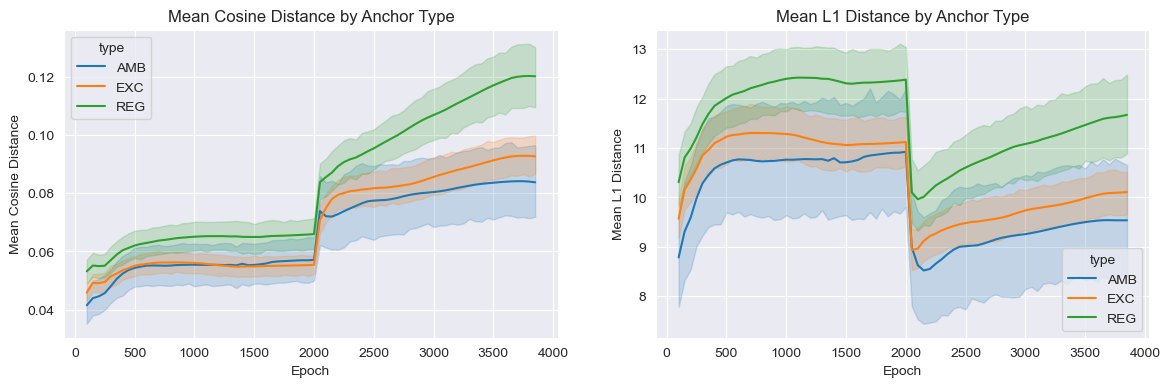

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

sns.lineplot(data=results_df, x='epoch', y='mean_cosine_distance', hue='type', ax=ax1, ci=68)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Mean Cosine Distance')
ax1.set_title(f'Mean Cosine Distance by {TYPE.title()} Type')

sns.lineplot(data=results_df, x='epoch', y='mean_l1_distance', hue='type', ax=ax2, ci=68)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean L1 Distance')
ax2.set_title(f'Mean L1 Distance by {TYPE.title()} Type')

plt.show()

In the next 3 sets of graphs, we look at each regularity type individually, but combine all three dilution levels in the same plot.

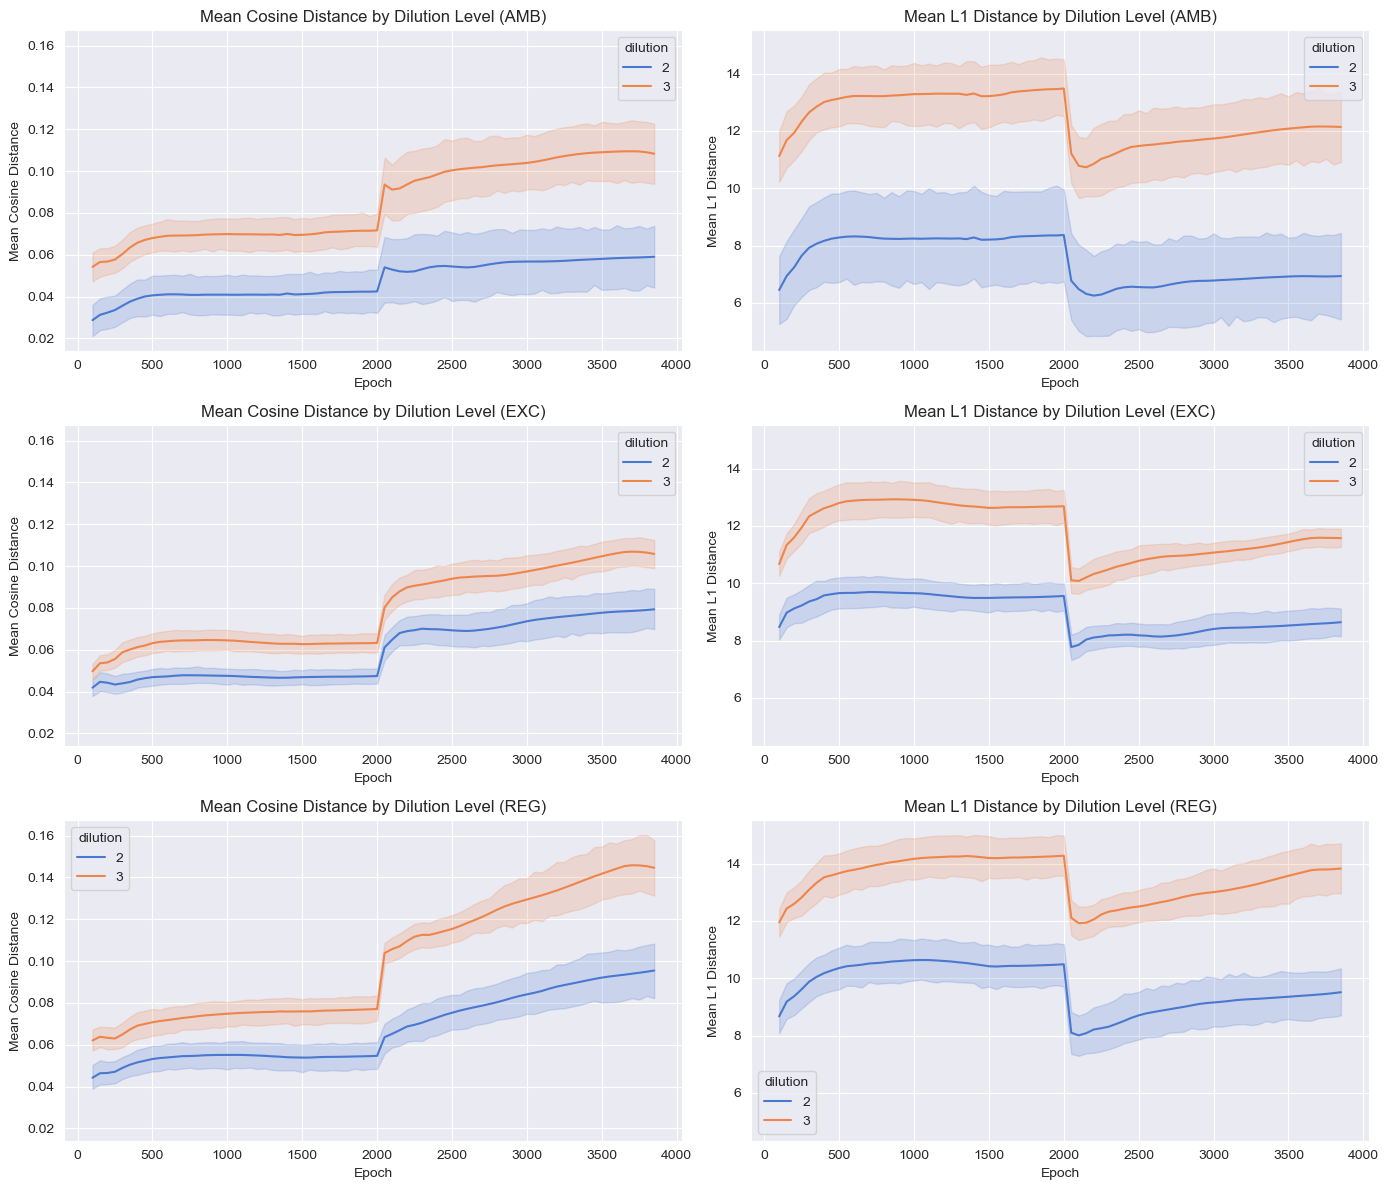

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for word_type, ax in zip(results_df['type'].unique(), axs):
    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_cosine_distance', hue='dilution',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Dilution Level ({word_type})')

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_l1_distance', hue='dilution',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Dilution Level ({word_type})')

plt.tight_layout()
plt.show()

In the next 3 sets of graphs, we look at each dilution level individually, but combine all three regularity types in the same plot.

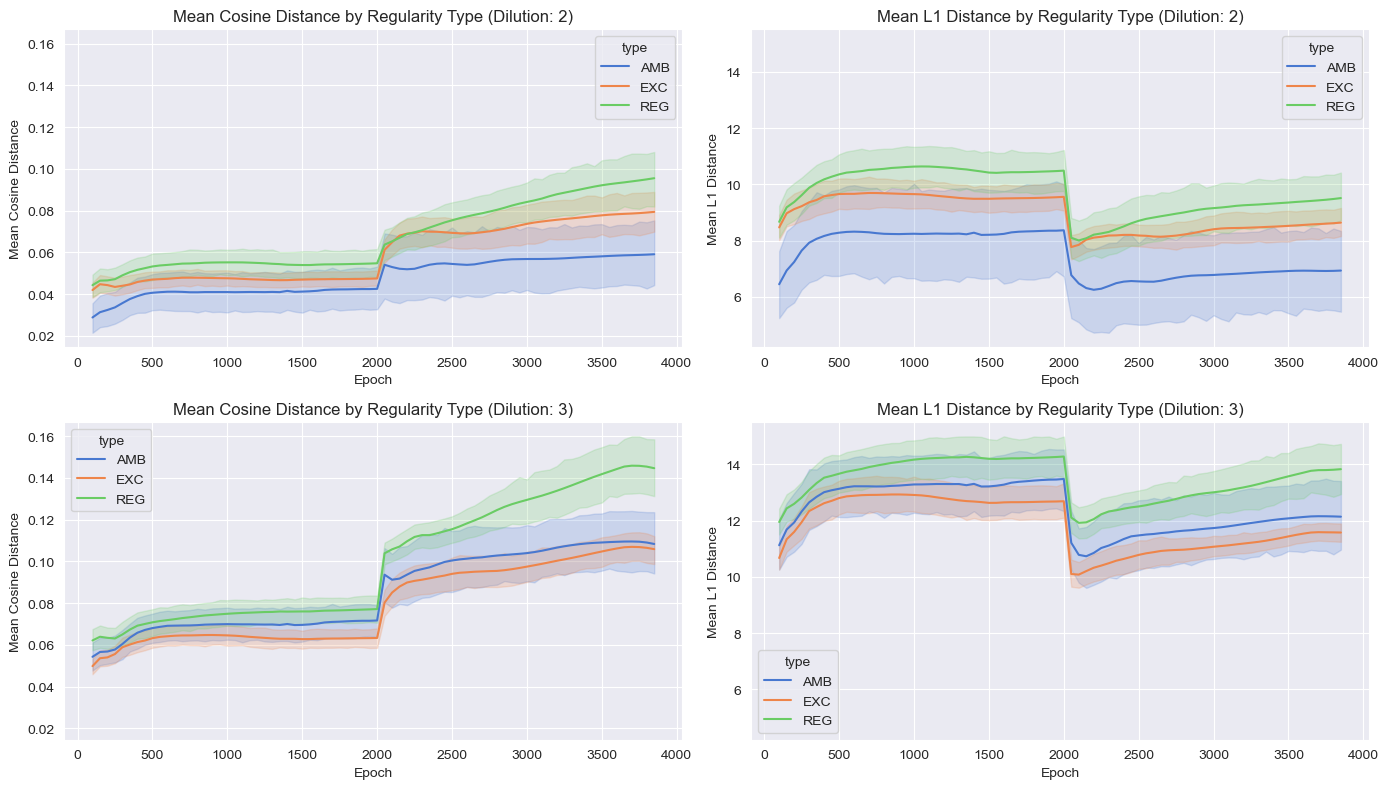

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8), sharey='col')

for dilution, ax in zip(results_df['dilution'].unique(), axs):
    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_cosine_distance', hue='type',
                 ax=ax[0], ci=68, palette='muted')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by Regularity Type (Dilution: {dilution})')

    sns.lineplot(data=results_df[results_df['dilution'] == dilution], x='epoch', y='mean_l1_distance', hue='type',
                 ax=ax[1], ci=68, palette='muted')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by Regularity Type (Dilution: {dilution})')

plt.tight_layout()
plt.show()

## Distance by Word Set
* We refer to each anchor/probe set by the first anchor/probe.

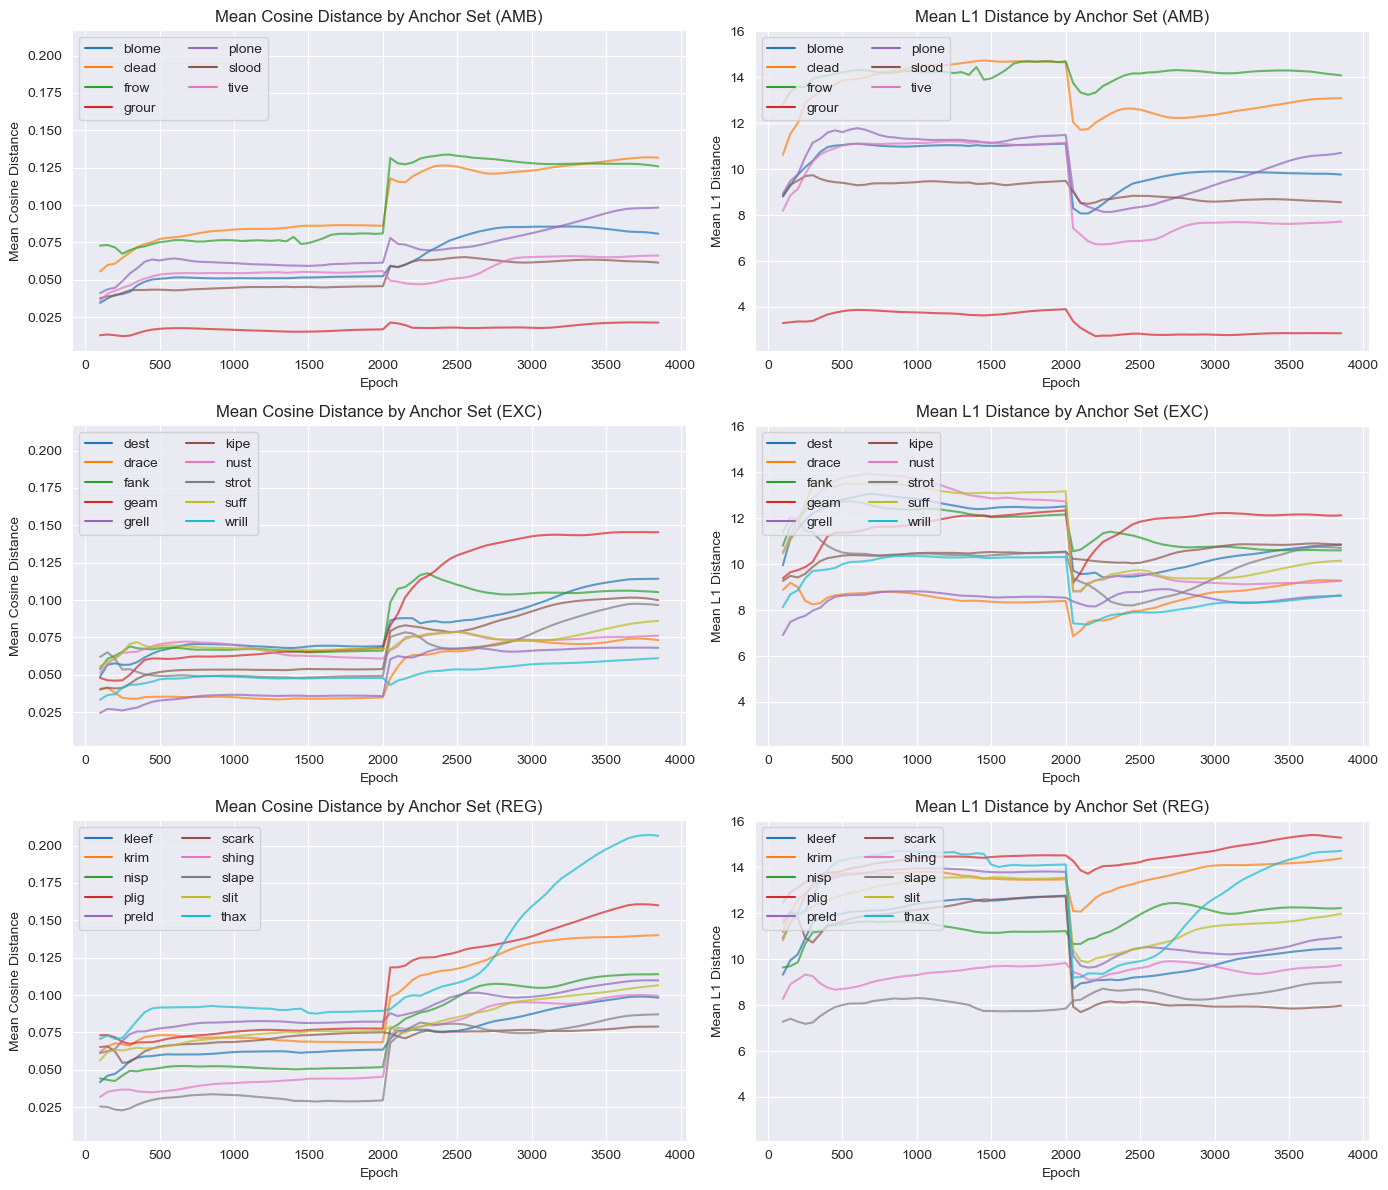

In [13]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12), sharey='col')

for word_type, ax in zip(results_df['type'].unique(), axs):
    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_cosine_distance', hue='first_anchor',
                 alpha=0.7, ax=ax[0], ci=None)
    ax[0].legend(ncol=2, loc='upper left')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Mean Cosine Distance')
    ax[0].set_title(f'Mean Cosine Distance by {TYPE.title()} Set ({word_type})')

    sns.lineplot(data=results_df[results_df['type'] == word_type], x='epoch', y='mean_l1_distance', hue='first_anchor',
                 alpha=0.7, ax=ax[1], ci=None)
    ax[1].legend(ncol=2, loc='upper left')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Mean L1 Distance')
    ax[1].set_title(f'Mean L1 Distance by {TYPE.title()} Set ({word_type})')

plt.tight_layout()
plt.show()